In [1]:
import pandas as pd

links = pd.read_csv("data/links.csv")
nodes = pd.read_csv("data/nodes.csv")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
requirs = pd.read_csv("data/Errors.csv", header=None)
requirs = np.array(requirs)

req_links = requirs[0,:]
errs = list(requirs[1,:])

In [4]:
v = {}
for link in req_links:
    coords=links[['startX','endX','startY','endY']][links['link_id']==link].values[0]
    v[link] = [(coords[0],coords[2]),(coords[1], coords[3])]
  

## Strongly Connected Component

In [5]:
import tarjan

In [6]:
vertices = []
for link in v:
    vertices.append(v[link][0])
    vertices.append(v[link][1])
#    print(link)
    
vertices = list(set(vertices))

In [7]:
# #build start vertices-links dictionary

# l = {}
# for link in v:
#     cur_start = v[link][0]
#     if cur_start not in l:
#         l[cur_start] = [link]
#     else:
#         l[cur_start].append(link)

        

In [41]:
thresholds = list(range(10,95))
linkslists = []
v_out_list = []
for i in range(len(thresholds)):
    threshold = thresholds[i]
    qualifiedIdx = [errs.index(t) for t in errs if t is not np.nan and int(t)<threshold]
    qualifiedIdx = list(set(qualifiedIdx))
    qualifiedLinks = [req_links[idx] for idx in qualifiedIdx]

    vertices = []
    start_vertices = []
    v_out = {}
    for link in qualifiedLinks:
        coords=links[['startX','endX','startY','endY']][links['link_id']==link].values[0]
        if v[link][0] not in v_out:
            v_out[v[link][0]] = []
        v_out[v[link][0]].append(v[link][1])
        
        
    for n in list(v_out.keys()):
        for nb in v_out[n]:
            if nb not in v_out:
                v_out[nb] = []

    v_out_list.append(v_out)
    
    temp = tarjan.tarjan(v_out)
    #components = [temp[j] for j in range(len(temp)) if len(temp[j])>1]
    components = temp
    if i % 10 == 0:
        print("components = " , len(components))
    linkslists.append(components)

components =  0
components =  48
components =  84
components =  86
components =  87
components =  93
components =  78
components =  50
components =  62


## Count Path based on Mate-Graph

In [42]:
#build meta-graph

def countPaths(graph, scc):

    scc_ref = {}

    for i in range(len(scc)):
        for n in scc[i]:
            scc_ref[n] = 'scc_' + str(i)

    #print(scc)
    #print(scc_ref)

    metagraph = {}

    for n in graph:
        scc_node = scc_ref[n]
        if scc_node in metagraph:
            current_node = metagraph[scc_node]
        else:
            current_node = set()

        new_node = set([scc_ref[neighbor]  for neighbor in graph[n] if scc_ref[neighbor] != scc_node])

        metagraph[scc_node] = current_node.union(new_node)

    #print(metagraph)


    sources = set(metagraph.keys())

    for n, neighbors, in metagraph.items():
        for nb in neighbors:
            try:
                sources.remove(nb)
            except:
                pass

    cache = {}
    def paths(node):
        if node in cache:
            return cache[node]

        if len(metagraph[node]) == 0:
            return 1

        cache[node] = np.sum([paths(nb) for nb in metagraph[node]])
        return cache[node]

    return(np.sum([paths(ss) for ss in sources]))

In [45]:
count_list = []
for graph, scc in zip(v_out_list, linkslists):   
    c = countPaths(graph,scc)
    count_list.append(c)

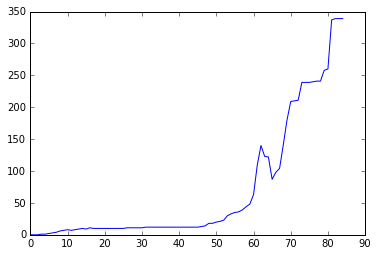

In [48]:
plt.plot(count_list)

In [13]:
a = [1,2,3,4,56]
a[-1]

56

In [9]:
orderDic = {}
orderDicList = []

#108512 in order 
count = 0
for perThres in linkslists:
    #perThres = linkslists[20]
    for perComp in perThres:
        #get the minimum order in this component if exist, get the order for this component
        orders = [orderDic[link] for link in perComp if link in orderDic]
        if len(orders) == 0:
            count = count + 1
            minOrder = count
        else:
            minOrder = min(orders)
        #sign the link with minimum order
        for link in perComp:
            orderDic[link] = minOrder
    #print(len(orderDic))
    #temp = copy.deepcopy(orderDic)
    #deep copy
    temp = {}
    for key in orderDic:
        temp[key] = orderDic[key]
    orderDicList.append(temp)

In [10]:
maxn = []
#print(orderDicList[12])
#print(max(orderDicList[12].values()))

for orderDic in orderDicList:
    if len(orderDic) is not 0:
        n = max(orderDic.values())
        maxn.append(n)

n = max(maxn)
print(n)
begin = []
life = []
for i in range(1,(n+1)):
    count = 0
    for j in range(len(orderDicList)):
        if i in orderDicList[j].values():
            if count == 0:
                beginP = j+1
            count = count+1
        #elif i == 1 and i not in orderDicList[j].values():
            #print(j)
    begin.append(beginP)
    life.append(count)

132


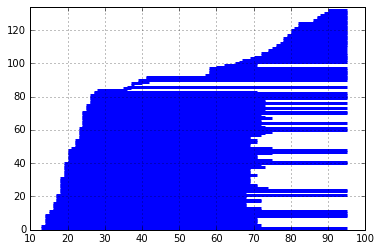

In [11]:
begin = np.array(begin)+9
end = np.array(begin) + np.array(life)

fig0=plt.figure()
#y = [(i+1) for i in range(len(barcode))]
y = [(i+1) for i in range(len(life))]
#x = [(barcode[i][1]+barcode[i][0])/2 for i in range(len(barcode))]
x = [(begin[i] + end[i])/2 for i in range(len(life))]
#x_err = [(barcode[i][1]-barcode[i][0])/2 for i in range(len(barcode))]
x_err = [(begin[i] - end[i])/2 for i in range(len(life))]
_, caps, _ = plt.errorbar(x=x, y=y, xerr=x_err, ls='',
                          elinewidth=3, capsize=5)
for cap in caps:
    cap.set_markeredgewidth(0)
plt.grid(True)

# Set the y-range so we can see all the errorbars clearly
plt.ylim(0, len(life)+2)
plt.show()



## check strongly components

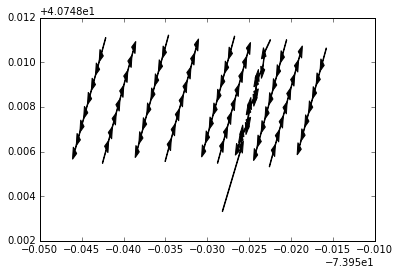

In [87]:
plt.xlim([-74,-73.96])
plt.ylim([40.75,40.76])
for key,value in v_out.items():
    for end in value:
        plt.arrow(key[0], key[1], (end[0]-key[0]), (end[1]-key[1]),width = 0.00005, head_width=0.0005, head_length=0.0005, 
               fc='k', ec='k')
plt.show()

In [6]:
def connectedComponent(v, visit):
    queue = []
    perThreshold = []
    #neighbors dictionary
    neighbor = {}
    for vertex in vertices_sets:
        neighbor[vertex] = []
        
    component = 0
    for i in range(len(vertices_sets)):
            #pick an unvisited point
            if visit[vertices_sets[i]] == False:
                queue.append(vertices_sets[i])
                perCompL = []
                while len(queue)!=0:
                    #flag as visit, and pop
                    cur = queue.pop(0)
                    visit[cur] = True            
                    #find unvisited neighbor, push it to queue, and push it to neighbor dictionary
                    for link in qualifiedLinks:
                        if cur == v[link][0] and visit[v[link][1]] == False:
                            queue.append(v[link][1])
                            neighbor[cur].append(v[link][1])
                            perCompL.append(link)
                        elif cur == v[link][1] and visit[v[link][0]] == False:
                            queue.append(v[link][0])
                            neighbor[cur].append(v[link][0])
                            perCompL.append(link)
                        #print("curLink = " + str(link) + "currnet component" + str(perCompL))
                component = component + 1
                perThreshold.append(perCompL)
    return component,perThreshold

In [9]:
thresholds = list(range(10,71))
num_cc = []
linkslists = [] 

for i in range(len(thresholds)):
#    i = 20
    threshold = thresholds[i]
    qualifiedIdx = [errs.index(t) for t in errs if t is not np.nan and int(t)<threshold]
    qualifiedIdx = list(set(qualifiedIdx))
    qualifiedLinks = [req_links[idx] for idx in qualifiedIdx]
    #print("qualify: " + str(qualifiedLinks))
    
    vertices = []
    for link in qualifiedLinks:
        coords=links[['startX','endX','startY','endY']][links['link_id']==link].values[0]
        vertices.append(v[link][0])
        vertices.append(v[link][1])
    vertices_sets = list(set(vertices))
    
    
    visit = {}
    for vertex in vertices_sets:
        visit[vertex] = False
        
    num_components, perThreshold = connectedComponent(v,visit)
    linkslists.append(perThreshold)
    num_cc.append(num_components)
    if i % 10 == 0 or i > 70:
        print('err = '+str(thresholds[i]) + " has cc =" + str(num_components))



err = 10 has cc =0
err = 20 has cc =8
err = 30 has cc =10
err = 40 has cc =10
err = 50 has cc =11
err = 60 has cc =10
err = 70 has cc =3


In [62]:
linkslists[60]

[[161318.0,
  195238.0,
  203555.0,
  204692.0,
  146916.0,
  159427.0,
  160112.0,
  168291.0,
  161028.0,
  194912.0,
  194930.0,
  146916.0,
  159427.0,
  160112.0,
  168291.0,
  161028.0,
  194912.0,
  194930.0,
  146531.0,
  146600.0,
  147226.0,
  168289.0,
  168551.0,
  168570.0,
  168289.0,
  168551.0,
  168570.0,
  194902.0,
  194946.0,
  146531.0,
  146600.0,
  147226.0,
  168289.0,
  168551.0,
  168570.0,
  168289.0,
  168551.0,
  168570.0,
  194902.0,
  194946.0,
  203126.0,
  146626.0,
  168582.0,
  120383.0,
  158630.0,
  168533.0,
  168582.0,
  120383.0,
  158630.0,
  168533.0,
  168582.0,
  194888.0,
  203126.0,
  146626.0,
  168582.0,
  120383.0,
  158630.0,
  168533.0,
  168582.0,
  120383.0,
  158630.0,
  168533.0,
  168582.0,
  194888.0,
  148462.0,
  195183.0,
  147268.0,
  168599.0,
  119161.0,
  168599.0,
  119161.0,
  168599.0,
  194881.0,
  148462.0,
  147268.0,
  168599.0,
  119161.0,
  168599.0,
  119161.0,
  168599.0,
  194881.0,
  146462.0,
  167734.0,
  19

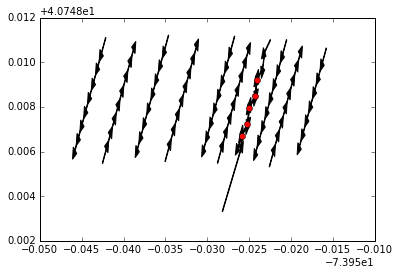

[-73.9709918 -73.9714516  40.7583747  40.7577482]


In [88]:
i = 29
threshold = thresholds[i]
qIdx = [errs.index(t) for t in errs if t is not np.nan and int(t)<threshold]
qIdx = list(set(qIdx))
qualified = [req_links[idx] for idx in qIdx]

colors = ['r', 'g', 'b']
count = 0
plt.figure(0)
#link = qualified[0]
for i in range(len(temp)):
    if len(temp[i])>1:
        for c in temp[i]:
            plt.plot([c[0]], [c[1]], marker='o', color=colors[count])
        count += 1

for link in qualified:
    coords=links[['startX','endX','startY','endY']][links['link_id']==link].values[0]
    plt.xlim([-74,-73.96])
    plt.ylim([40.75,40.76])
    plt.arrow(coords[0], coords[2], (coords[1]-coords[0]), (coords[3]-coords[2]),width = 0.00005, head_width=0.0005, head_length=0.0005, 
               fc='k', ec='k')
plt.show()

print(coords)

In [37]:
i = 29
threshold = thresholds[i]
qIdx = [errs.index(t) for t in errs if t is not np.nan and int(t)<threshold]
qIdx = list(set(qIdx))
qualified = [req_links[idx] for idx in qIdx]

import folium
from folium.features import (WmsTileLayer, RegularPolygonMarker, Vega, GeoJson,
                       CircleMarker, LatLngPopup,
                       ClickForMarker, TopoJson, PolyLine, MultiPolyLine,
                       )
NY_COORDINATES = (40.7472,-73.98)

m =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=14)

c = 1

for link in qualified:
    coords=links[['startX','endX','startY','endY']][links['link_id']==link].values[0]
    loc=[[coords[2],coords[0]],[coords[3],coords[1]]]
    m.add_children(PolyLine(locations=loc,color='red'))
    c = c+1
    



In [38]:
m

In [32]:
orderDic = {}
orderDicList = []

#108512 in order 
count = 0
for perThres in linkslists:
    #perThres = linkslists[20]
    for perComp in perThres:
        #get the minimum order in this component if exist, get the order for this component
        orders = [orderDic[link] for link in perComp if link in orderDic]
        if len(orders) == 0:
            count = count + 1
            minOrder = count
        else:
            minOrder = min(orders)
        #sign the link with minimum order
        for link in perComp:
            orderDic[link] = minOrder
    #print(len(orderDic))
    #temp = copy.deepcopy(orderDic)
    #deep copy
    temp = {}
    for key in orderDic:
        temp[key] = orderDic[key]
    orderDicList.append(temp)

In [92]:
# orderDicList[60]

In [91]:
maxn = []
#print(orderDicList[12])
#print(max(orderDicList[12].values()))

for orderDic in orderDicList:
    if len(orderDic) is not 0:
        n = max(orderDic.values())
        maxn.append(n)

n = max(maxn)
print(n)
begin = []
life = []
for i in range(1,(n+1)):
    count = 0
    for j in range(len(orderDicList)):
        if i in orderDicList[j].values():
            if count == 0:
                beginP = j+1
            count = count+1
        #elif i == 1 and i not in orderDicList[j].values():
            #print(j)
    begin.append(beginP)
    life.append(count)

19


In [92]:
print(len(orderDicList))

61


In [95]:
begin = np.array(begin)+9

In [100]:
begin

array([13, 15, 16, 17, 18, 18, 18, 19, 19, 20, 20, 22, 23, 23, 24, 24, 26,
       26, 41])

In [96]:
life

[58, 56, 2, 44, 49, 45, 1, 50, 1, 1, 36, 1, 41, 1, 40, 1, 43, 1, 30]

In [97]:
list(range(10,70,10))

[10, 20, 30, 40, 50, 60]

In [98]:
end = np.array(begin) + np.array(life)

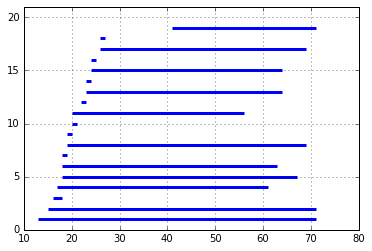

In [99]:
fig0=plt.figure()
#y = [(i+1) for i in range(len(barcode))]
y = [(i+1) for i in range(len(life))]
#x = [(barcode[i][1]+barcode[i][0])/2 for i in range(len(barcode))]
x = [(begin[i] + end[i])/2 for i in range(len(life))]
#x_err = [(barcode[i][1]-barcode[i][0])/2 for i in range(len(barcode))]
x_err = [(begin[i] - end[i])/2 for i in range(len(life))]
_, caps, _ = plt.errorbar(x=x, y=y, xerr=x_err, ls='',
                          elinewidth=3, capsize=5)
for cap in caps:
    cap.set_markeredgewidth(0)
plt.grid(True)

# Set the y-range so we can see all the errorbars clearly
plt.ylim(0, len(life)+2)
plt.show()
